In [2]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# Read data 

In [3]:
df_labels = pd.read_csv("dataset/train.csv")
df_photo_to_biz = pd.read_csv("dataset/train_photo_to_biz_ids.csv")
df = df_photo_to_biz.join(other=df_labels.set_index('business_id'), how='left', on='business_id').drop(columns="business_id")

In [4]:
df_train = df_labels
df_train["photos_id"] = df_labels["business_id"].apply(lambda x: " ".join(map(str,df_photo_to_biz[df_photo_to_biz.business_id == x].photo_id.values)))

In [5]:
df_train

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...
5,101,1 2 3 4 5 6,13736 393696 286907 86169 243460 254663 155961...
6,1011,2 3 5 6,372371 116870 411981 208597 127752 188395 1410...
7,1012,1 2 3 5 6,287385 232258 388225 151345 417121 327546 4362...
8,1014,1 2 4 5 6,407910 33911 269241 374218 256236 296370 30266...
9,1015,1 5 6 7,456770 44056 128542 373344 87938 148452 429399...


In [6]:
print(df_train.isnull().sum().sum())

4


In [7]:
df_train.dropna(inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [8]:
df_train

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...
5,101,1 2 3 4 5 6,13736 393696 286907 86169 243460 254663 155961...
6,1011,2 3 5 6,372371 116870 411981 208597 127752 188395 1410...
7,1012,1 2 3 5 6,287385 232258 388225 151345 417121 327546 4362...
8,1014,1 2 4 5 6,407910 33911 269241 374218 256236 296370 30266...
9,1015,1 5 6 7,456770 44056 128542 373344 87938 148452 429399...


Business attributes, that corresponds to labels:

0: good_for_lunch

1: good_for_dinner

2: takes_reservations

3: outdoor_seating

4: restaurant_is_expensive

5: has_alcohol

6: has_table_service

7: ambience_is_classy

8: good_for_kids


In [9]:
labels_str = [
    "good for lunch", "good for dinner", "takes reservations",
    "outdoor seating", "restaurant is expensive", "has alcohol",
    "has table service", "ambience is classy", "good for kids"
]

In [10]:
LABELS_NUM = 9

In [11]:
def encode_label(l):
    res = np.zeros(LABELS_NUM)
    for i in l:
        res[i] = 1
    return res

train_L = np.vstack(df_train['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split()))).apply(encode_label))
df_train = pd.concat([df_train, pd.DataFrame(train_L)], axis=1).drop(columns=["labels"])
df_train

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,101,13736 393696 286907 86169 243460 254663 155961...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,1011,372371 116870 411981 208597 127752 188395 1410...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
7,1012,287385 232258 388225 151345 417121 327546 4362...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
8,1014,407910 33911 269241 374218 256236 296370 30266...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
9,1015,456770 44056 128542 373344 87938 148452 429399...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [12]:
def show_image(opencv_image):
    b,g,r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r,g,b])
    plt.imshow(rgb_image)
    plt.show()

In [13]:
def get_img(img_id):
    return cv2.imread("dataset/train_photos/" + str(img_id) + ".jpg")

In [14]:
df_train

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,101,13736 393696 286907 86169 243460 254663 155961...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,1011,372371 116870 411981 208597 127752 188395 1410...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
7,1012,287385 232258 388225 151345 417121 327546 4362...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
8,1014,407910 33911 269241 374218 256236 296370 30266...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
9,1015,456770 44056 128542 373344 87938 148452 429399...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


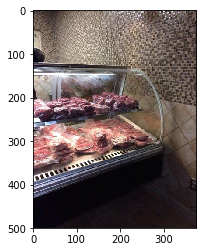

In [15]:
show_image(get_img(int(df.sample(1).photo_id)))

# Data investigating

## Class balance

In [16]:
def show_classes_count(df):
    labels = df.drop(columns=["photos_id", "business_id"])
    labels_count = []
    for i in range(LABELS_NUM):
        labels_count.append(df[i].sum())
    plt.bar(x=range(LABELS_NUM), height=labels_count, tick_label=labels_str)

Generally, it is hard task to balance classes in multi-label classification, but let's try to do it in easy way. First, let's use upsampling for good for lunch, as it has the smallest amount os samples

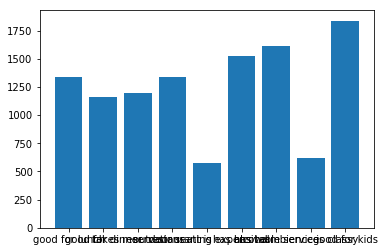

In [17]:
show_classes_count(df_train.append(df_train[df_train[0] == 1]))

We can see, that it improved the situation, but we have much more samples from 5 and 6 labels comparing to 4 and 7. So let's use downsampling for 5 and 6 classes, but while removing samples take into account, that samples, that have 0, 4 and 7 classes don't remove

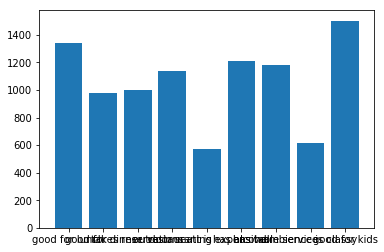

In [18]:
a = df_train[df_train[6] == 1]
a = df_train[df_train[5] == 1].append(a[a[5] == 0])
a = a[a[7] == 0]
a = a[a[4] == 0]
a = a[a[0] == 0]
a = df_train.iloc[list(set(df_train.index) - set(a.index))]
balanced_df = a.append(a[a[0] == 1])
show_classes_count(balanced_df)

For now, 7 classs could have more samples, but generally classes are much more balanced

# Feature extraction

## Inception

In [19]:
from keras.applications import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [25]:
def modify_model(original_model):
    bottleneck_input = original_model.get_layer(index=0).input
    bottleneck_output = original_model.get_layer(index=0).output
    bottleneck_model = Model(inputs=bottleneck_input, outputs=bottleneck_output)

    for layer in bottleneck_model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(bottleneck_model)
    new_model.add(Dense(LABELS_NUM, activation='softmax', input_dim=2048))
    new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return new_model

In [21]:
model = modify_model(InceptionV3())

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [30]:
def id_to_img(row):
    images = []
    for img_id in row.photos_id:
        img = get_img(img_id)
        if img is not None:
            images.append(img)
    row.photos_id = images
    return row

In [31]:
def interp_and_add(df):
    return df.apply(lambda x: id_to_img(x), axis=1)

In [ ]:
interp_and_add(df_train[:5])

In [ ]:
def split_and_stratify(df, percn_to_ignore):
    y = df.drop(["photo_id"], axis=1)
    X_stratified, _ = train_test_split(df, test_size=percn_to_ignore, random_state=42, stratify=y)
    
    return X_stratified